In [19]:
import pandas as pd
import numpy as np
import pickle
from sklearn.metrics import classification_report , confusion_matrix ,accuracy_score,f1_score,precision_score,recall_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_fscore_support


In [3]:
#Loading validation data 
val_df=pd.read_csv('../data/processed/val.csv')
X_val=val_df['property_address']
y_val=val_df['categories']

In [5]:
#loading model and making prediction

#loading vectorizer
with open('../best_model/vectorizer.pkl','rb') as f:
    vectorizer=pickle.load(f)

#load model
with open('../best_model/traditional_model.pkl','rb') as f:
    model = pickle.load(f)

#Load label encoder 
with open('../best_model/label_encoder.pkl','rb') as f:
    le=pickle.load(f)

#transform validation data 
X_val_tf=vectorizer.transform(X_val)

#Predictions
y_pred_encoded=model.predict(X_val_tf)
y_pred = le.inverse_transform(y_pred_encoded)

print('Validation set size :',len(y_val))
print('Clasees: ',le.classes_)

Validation set size : 1722
Clasees:  ['commercial unit' 'flat' 'houseorplot' 'landparcel' 'others']


In [6]:
#Overall metrics
#Calculating main metrices 

accuracy=accuracy_score(y_val,y_pred)
macro_f1=f1_score(y_val,y_pred,average='macro')
weighted_f1=f1_score(y_val,y_pred,average='weighted')
macro_precision=precision_score(y_val,y_pred,average='macro')
macro_recall=recall_score(y_val,y_pred,average='macro')

print('Overall Metrics')
print('Accuracy: ',accuracy)
print('Macro F1: ',macro_f1)
print('Macro Precision :',macro_precision)
print('Macro Recall:',macro_recall)
print('Weighted F1: ',weighted_f1)


Overall Metrics
Accuracy:  0.4326364692218351
Macro F1:  0.3258860235612556
Macro Precision : 0.32867187421891286
Macro Recall: 0.33279264844744744
Weighted F1:  0.41238681213432504


In [8]:
#Classification Report
report=classification_report(y_val,y_pred,output_dict=True)
print('\nClassification Report ')
print(classification_report(y_val,y_pred))

#Save report to dict for Later
report_df=pd.DataFrame(report).transpose()
report_df.to_csv('../reports/classification_report.csv',index=True)



Classification Report 
                 precision    recall  f1-score   support

commercial unit       0.05      0.02      0.02       191
           flat       0.55      0.63      0.59       622
    houseorplot       0.42      0.48      0.45       499
     landparcel       0.36      0.25      0.29       171
         others       0.26      0.30      0.28       239

       accuracy                           0.43      1722
      macro avg       0.33      0.33      0.33      1722
   weighted avg       0.40      0.43      0.41      1722



Text(0.5, 23.52222222222222, 'Predicted label')

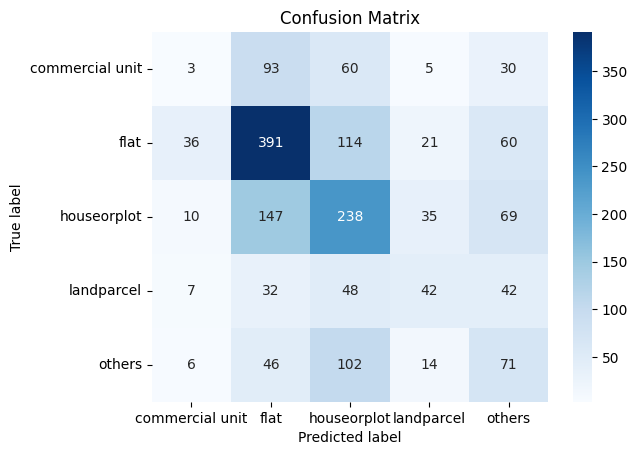

In [17]:
#Confusion Matrix

cm=confusion_matrix(y_val,y_pred,labels=le.classes_)

#plotting confusion matrix
sns.heatmap(cm,annot=True,fmt='d',cmap='Blues',xticklabels=le.classes_,yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')



Text(50.72222222222221, 0.5, 'True label')

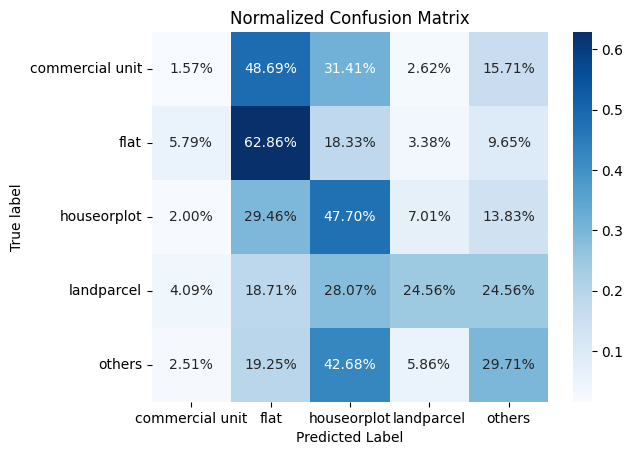

In [14]:
#Normalised confusion Matrix (percentage)
cm_normalized=cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]

sns.heatmap(cm_normalized,fmt='.2%',annot=True,cmap='Blues',xticklabels=le.classes_,yticklabels=le.classes_)
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True label')

In [20]:
#Per-Class Metrics

precision,recall,f1,support = precision_recall_fscore_support(
    y_val,y_pred,labels=le.classes_,average=None)

per_class_df = pd.DataFrame({
    'Class':le.classes_,
    'Precision':precision,
    'Recall':recall,
    'F1-score':f1,
    'Support':support
})

#Adding percentage of total
per_class_df['Percentage'] = (per_class_df['Support']/len(y_val)*100).round(2)

print("Per Class Performance")
print(per_class_df.to_string(index=False))

per_class_df.to_csv('../reports/per_class_metrics.csv',index=False)

Per Class Performance
          Class  Precision   Recall  F1-score  Support  Percentage
commercial unit   0.048387 0.015707  0.023715      191       11.09
           flat   0.551481 0.628617  0.587528      622       36.12
    houseorplot   0.423488 0.476954  0.448633      499       28.98
     landparcel   0.358974 0.245614  0.291667      171        9.93
         others   0.261029 0.297071  0.277886      239       13.88


Text(0, 0.5, 'F1-score')

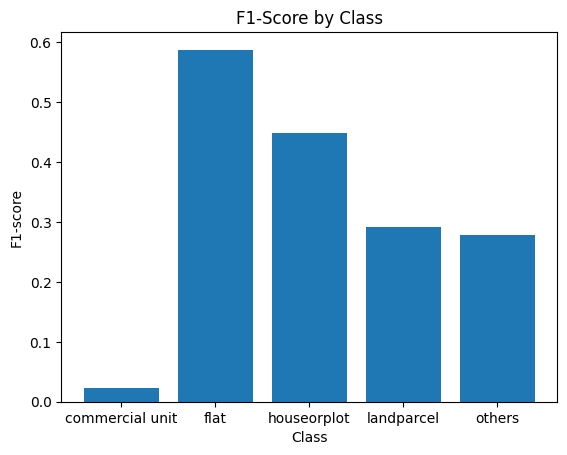

In [21]:
#Visualize Per class F1 score

plt.bar(per_class_df['Class'],per_class_df['F1-score'])
plt.title('F1-Score by Class')
plt.xlabel('Class')
plt.ylabel('F1-score')


In [22]:
#Error analysis -Finding misclassified examples

errors=val_df[y_val != y_pred].copy()
errors['predicted']=y_pred[y_val != y_pred]

#Summary
total_errors = len(errors)
error_percent=total_errors/len(y_val)*100
print(f"Total errors : ",error_percent)

#Errors by true class
print("\nErrors By class:")
print(errors['categories'].value_counts())

#Most common confusion pairs
errors['confusion']=errors['categories']+errors['predicted']
print("\nTop misclassification ")
print(errors['confusion'].value_counts().head(5))



Total errors :  56.736353077816496

Errors By class:
categories
houseorplot        261
flat               231
commercial unit    188
others             168
landparcel         129
Name: count, dtype: int64

Top misclassification 
confusion
houseorplotflat        147
flathouseorplot        114
othershouseorplot      102
commercial unitflat     93
houseorplotothers       69
Name: count, dtype: int64


In [29]:
#Summary Report 
print("Model Evaluation Summary")

print("Modelk: Traditional ML(TF-IDF)",type(model).__name__)
print('\nValidation Set Size:',len(y_val))

print('\nOverall Metrics')
print("\nAccuracy: ",accuracy)
print('\nMacro F1-score:',macro_f1)
print('\nMacro Precision: ',macro_precision)
print('\nMacro Recall:',macro_recall)
print('\nWeighted F1-Score',weighted_f1)
print('\nPER-CLASS PERFORMANCE')
print(per_class_df.to_string(index=False))

print('\nError Analysis',len(errors))
print(f"{len(errors)/len(y_val)*100:.2f}%")


Model Evaluation Summary
Modelk: Traditional ML(TF-IDF) LogisticRegression

Validation Set Size: 1722

Overall Metrics

Accuracy:  0.4326364692218351

Macro F1-score: 0.3258860235612556

Macro Precision:  0.32867187421891286

Macro Recall: 0.33279264844744744

Weighted F1-Score 0.41238681213432504

PER-CLASS PERFORMANCE
          Class  Precision   Recall  F1-score  Support  Percentage
commercial unit   0.048387 0.015707  0.023715      191       11.09
           flat   0.551481 0.628617  0.587528      622       36.12
    houseorplot   0.423488 0.476954  0.448633      499       28.98
     landparcel   0.358974 0.245614  0.291667      171        9.93
         others   0.261029 0.297071  0.277886      239       13.88

Error Analysis 977
56.74%
